# Redes Generativas Adversarias (GAN) 

En este cuaderno vamos a construir una red GAN básica

---

    [ES] Código de Alfredo Cuesta Infante para 'Reconocimiento de Patrones'
       @ Master Universitario en Visión Artificial, 2020, URJC (España)
    [EN] Code by Alfredo Cuesta-Infante for 'Pattern Recognition'
       @ Master of Computer Vision, 2020, URJC (Spain)

    alfredo.cuesta@urjc.es 

In [1]:
#-[0]. General purpose packages

import numpy as np
import matplotlib.pyplot as plt
np.random.seed(2020) ##<- for reproducibility

#-[1]. Load images. Keras has a few benchmark datasets readily available.

from tensorflow.keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

#--- Get info of train and test data sets
N_train,dim0,dim1 = X_train.shape
N_test,dim0,dim1  = X_test.shape
# The dimension of the flattened real examples 
input_dim = dim0*dim1
#--> NOTICE THAT 'input_dim' is a global variable

# the data, shuffled and split between train and test sets
X_train = X_train.reshape(N_train, input_dim)
X_test = X_test.reshape(N_test, input_dim)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test  /= 255

**Variables GLOBALES** que vamos a utilizar

*   `random_dim` : Dimensión del vector $z$, que genera las imágenes
*   `input_dim`  : Dimensión del vector $x$, obtenido del conjunto de entrenamiento

In [2]:
# To make sure that we can reproduce the experiment and get the same results
np.random.seed(2020)

# The dimension of our random noise vector, that is transformed into fake examples
random_dim = 100 

# The dimension of the flattened real examples 
# input_dim = dim0*dim1 <-- already initialized

## Construcción de los módulos de la GAN



In [3]:
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import initializers
from tqdm import tqdm #<-- para mostrar barras de progreso al ejecutar for

**Optimizador**

In [4]:
#  Function that returns the optimizer

def get_optimizer():
    return Adam(lr=0.0002, beta_1=0.5)

### Red Generadora

In [5]:
# Function that returns the GENERATOR network

def get_generator(optimizer):
    generator = Sequential()
    generator.add(Dense(256, input_dim=random_dim, 
                        kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    #--> REMEMBER THAT 'random_dim' is a global variable
    
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(512))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(1024))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(784, activation='tanh'))
    generator.compile(loss='mse', optimizer=optimizer)
    #generator.compile(loss='binary_crossentropy', optimizer=optimizer) #<-alternative with another loss
    return generator

### Red Discriminadora

In [6]:
# Function that returns the DISCRIMINATOR network

def get_discriminator(optimizer):
    discriminator = Sequential()
    discriminator.add(Dense(1024, input_dim=input_dim, 
                            kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    #--> REMEMBER THAT 'input_dim' is a global variable
    
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(256))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(1, activation='sigmoid')) 
    #--> 1 single neuron that predicts whether the given example is true or fake.
    #    in other words, it gives the prob. of being true = 1-prob of being fake
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return discriminator

### Red GAN

In [7]:
# GAN

def get_gan_network(discriminator, random_dim, generator, optimizer):
    # We initially set trainable to False since we only want to train either the
    # generator or discriminator at a time
    discriminator.trainable = False
    # gan input (noise) will be 100-dimensional vectors
    gan_input = Input(shape=(random_dim,))
    # the output of the generator (an image)
    x = generator(gan_input)
    # get the output of the discriminator (probability of image being real or not)
    gan_output = discriminator(x)
    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=optimizer)
    return gan

### Función para ver resultados

In [8]:
# Create a wall of generated MNIST images
def plot_generated_images(epoch, generator, examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, random_dim])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    #- plt.savefig('gan_generated_image_epoch_%d.png' % epoch)

## Aprendizaje

In [9]:
def train(epochs=1, batch_size=128):
    # TRAIN and TEST datasets and labels are global variables
    # Split the training data into batches of size 128
    batch_count = int( X_train.shape[0] / batch_size )

    # Build our GAN netowrk
    adam = get_optimizer()
    generator = get_generator(adam)
    discriminator = get_discriminator(adam)
    gan = get_gan_network(discriminator, random_dim, generator, adam)

    for e in range(1, epochs+1):
        print( '-'*15, 'Epoch %d' % e, '-'*15)
        for _ in tqdm( range(batch_count) ):

            #----- FIRST: we train D & G -----
            # - prepare examples of both real and fake
            # - set discriminator.trainable = True

            # Get a random set of input noise and images
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            image_batch = X_train[np.random.randint(0, X_train.shape[0], size=batch_size)]

            # Generate fake MNIST images
            generated_images = generator.predict(noise)
            X = np.concatenate([image_batch, generated_images])

            # Labels for generated and real data
            y_dis = np.zeros(2*batch_size)
            # One-sided label smoothing
            y_dis[:batch_size] = 0.9

            # Train discriminator
            discriminator.trainable = True
            discriminator.train_on_batch(X, y_dis)

            #----- SECOND: we train G -----
            # - prepare only fake examples and label them as True
            # - set discriminator.trainable = False            

            # Train generator
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            y_gen = np.ones(batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y_gen)

        if e == 1 or e % 20 == 0:
            plot_generated_images(e, generator)

  0%|          | 0/937 [00:00<?, ?it/s]

--------------- Epoch 1 ---------------


  0%|          | 1/937 [00:00<01:34,  9.92it/s]

--------------- Epoch 2 ---------------


  0%|          | 2/937 [00:00<01:17, 12.03it/s]

--------------- Epoch 3 ---------------


  0%|          | 2/937 [00:00<01:11, 13.16it/s]

--------------- Epoch 4 ---------------


  0%|          | 2/937 [00:00<01:10, 13.25it/s]

--------------- Epoch 5 ---------------


  0%|          | 2/937 [00:00<01:15, 12.42it/s]

--------------- Epoch 6 ---------------


  0%|          | 2/937 [00:00<01:20, 11.62it/s]

--------------- Epoch 7 ---------------


  0%|          | 2/937 [00:00<01:17, 12.08it/s]

--------------- Epoch 8 ---------------


  0%|          | 2/937 [00:00<01:18, 11.86it/s]

--------------- Epoch 9 ---------------


  0%|          | 2/937 [00:00<01:17, 12.04it/s]

--------------- Epoch 10 ---------------


100%|██████████| 937/937 [01:13<00:00, 12.80it/s]


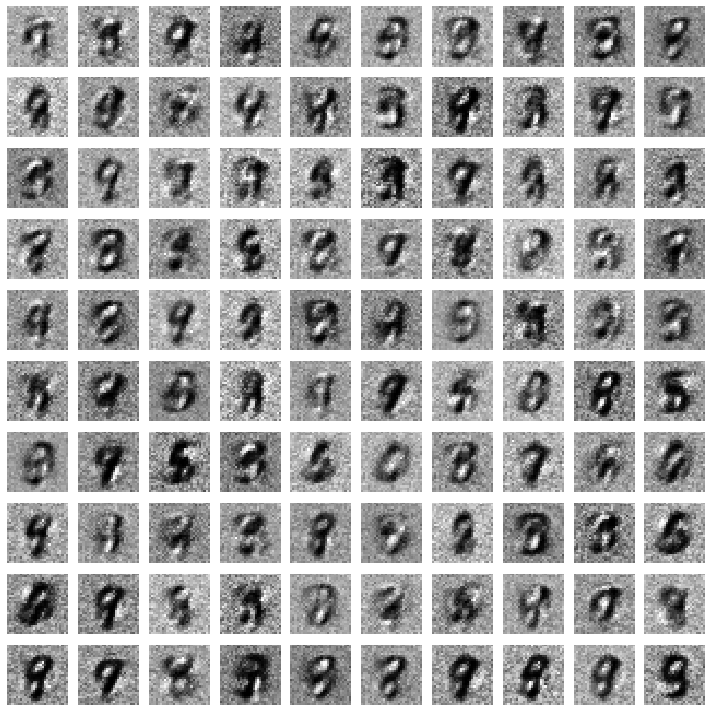

In [10]:
epochs=10
batch_size=64

train(epochs=epochs, batch_size=batch_size)

**Aunque las imágenes son bastante ruidosas, se puede apreciar una tendencia al 8 y al 9, es decir sufre de _MODE COLLAPSE_**
